## Transformer with tensorflow

In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, Dropout, Add, LayerNormalization

# Load the dataset
file_path = 'Duke.xlsx'  # Replace with your file path
data = pd.ExcelFile(file_path)
df = data.parse('Sheet1')
df = df.sort_values(by='PublishDate')

# Convert PublishDate to datetime and set as index
df['PublishDate'] = pd.to_datetime(df['PublishDate'])
df.set_index('PublishDate', inplace=True)

# Extract relevant columns
selected_data = df[['Y1', 'Z1', 'Z2', 'Z3', 'Z4', 'Y2']]

# Add lag features for the past 7 days
for lag in range(1, 8):
    selected_data[f'Y2_lag_{lag}'] = selected_data['Y2'].shift(lag)


C:\Users\ji.702\AppData\Local\Temp\1\ipykernel_8228\3733697636.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data[f'Y2_lag_{lag}'] = selected_data['Y2'].shift(lag)
C:\Users\ji.702\AppData\Local\Temp\1\ipykernel_8228\3733697636.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data[f'Y2_lag_{lag}'] = selected_data['Y2'].shift(lag)
C:\Users\ji.702\AppData\Local\Temp\1\ipykernel_8228\3733697636.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [11]:
def create_sequences(data, target, time_steps, target_steps):
    encoder_inputs, decoder_inputs, targets = [], [], []
    for i in range(len(data) - time_steps - target_steps):
        # Encoder input: Last `time_steps` days
        encoder_inputs.append(data[i:i + time_steps])
        
        # Decoder input: Zeros for the first time step + covariates for target period
        decoder_inputs.append(data[i + time_steps - 1:i + time_steps + target_steps - 1])
        
        # Targets: Next `target_steps` days of Y2
        targets.append(target[i + time_steps:i + time_steps + target_steps])
    
    return np.array(encoder_inputs), np.array(decoder_inputs), np.array(targets)

# Drop rows with NaN values created by lagging
selected_data.dropna(inplace=True)

# Separate features and target
X = selected_data.drop(columns=['Y2'])
y = selected_data['Y2']

# Parameters
time_steps = 7  # Encoder input length
target_steps = 7  # Decoder output length

# Create sequences
encoder_inputs, decoder_inputs, targets = create_sequences(X, y, time_steps, target_steps)


C:\Users\ji.702\AppData\Local\Temp\1\ipykernel_8228\765423665.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data.dropna(inplace=True)


In [12]:
from sklearn.preprocessing import MinMaxScaler
# Normalize the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Recreate sequences with normalized data
encoder_inputs, decoder_inputs, targets = create_sequences(X_scaled, y_scaled, time_steps, target_steps)


In [13]:
from sklearn.model_selection import train_test_split

# Split into training (60%), validation (20%), and test (20%)
X_train, X_temp, decoder_train, decoder_temp, y_train, y_temp = train_test_split(
    encoder_inputs, decoder_inputs, targets, test_size=0.4, random_state=42)
X_val, X_test, decoder_val, decoder_test, y_val, y_test = train_test_split(
    X_temp, decoder_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train shapes: {X_train.shape}, {decoder_train.shape}, {y_train.shape}")
print(f"Validation shapes: {X_val.shape}, {decoder_val.shape}, {y_val.shape}")
print(f"Test shapes: {X_test.shape}, {decoder_test.shape}, {y_test.shape}")


Train shapes: (16346, 7, 12), (16346, 7, 12), (16346, 7, 1)
Validation shapes: (5449, 7, 12), (5449, 7, 12), (5449, 7, 1)
Test shapes: (5449, 7, 12), (5449, 7, 12), (5449, 7, 1)


In [14]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

class Encoder(nn.Module):
    def __init__(self, encoder_input_size, hidden_size):
        super().__init__()
        self.rnn = nn.RNN(encoder_input_size, hidden_size, batch_first=True)
        self.hidden_size = hidden_size

    def forward(self, encoder_inputs):
        # encoder_inputs: [batch_size, seq_len, input_size]
        outputs, hidden = self.rnn(encoder_inputs)
        return outputs, hidden
    
class Decoder(nn.Module):
    def __init__(self, decoder_input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.RNN(decoder_input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, decoder_inputs, encoder_outputs, hidden, teacher_force_probability=0.5):
        # decoder_inputs: [batch_size, seq_len, input_size]
        # encoder_outputs: [batch_size, seq_len, hidden_size]
        # hidden: [1, batch_size, hidden_size]
        
        batch_size, seq_len, _ = decoder_inputs.size()
        outputs = torch.zeros(batch_size, seq_len, 1).to(decoder_inputs.device)

        for t in range(seq_len):
            input_t = decoder_inputs[:, t, :].unsqueeze(1)  # [batch_size, 1, input_size]
            output, hidden = self.rnn(input_t, hidden)  # Output: [batch_size, 1, hidden_size]
            outputs[:, t, :] = self.fc(output.squeeze(1))  # [batch_size, 1]
        return outputs

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, encoder_inputs, decoder_inputs, targets=None, teacher_force_probability=0.5):
        # Encoder forward pass
        encoder_outputs, hidden = self.encoder(encoder_inputs)

        # Decoder forward pass
        outputs = self.decoder(decoder_inputs, encoder_outputs, hidden, teacher_force_probability)
        return outputs


In [16]:
# Define model parameters
encoder_input_size = X_train.shape[2]  # Number of features
decoder_input_size = X_train.shape[2]  # Same as encoder for simplicity
hidden_size = 64
output_size = 1  # Predict Y2

# Initialize model
encoder = Encoder(encoder_input_size, hidden_size)
decoder = Decoder(decoder_input_size, hidden_size, output_size)
model = Seq2Seq(encoder, decoder).to(device)

# Define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    encoder_inputs = torch.tensor(X_train).float().to(device)
    decoder_inputs = torch.zeros_like(encoder_inputs).to(device)  # Start with zeros
    targets = torch.tensor(y_train).float().to(device)

    outputs = model(encoder_inputs, decoder_inputs, targets, teacher_force_probability=0.5)

    # Compute loss
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")


Epoch 1/50, Loss: 0.16545960307121277
Epoch 2/50, Loss: 0.1378551870584488
Epoch 3/50, Loss: 0.11446909606456757
Epoch 4/50, Loss: 0.09461507946252823
Epoch 5/50, Loss: 0.07772611826658249
Epoch 6/50, Loss: 0.06335900723934174
Epoch 7/50, Loss: 0.05121408402919769
Epoch 8/50, Loss: 0.04113881662487984
Epoch 9/50, Loss: 0.03312882408499718
Epoch 10/50, Loss: 0.027308205142617226
Epoch 11/50, Loss: 0.023866133764386177
Epoch 12/50, Loss: 0.02290702797472477
Epoch 13/50, Loss: 0.024163058027625084
Epoch 14/50, Loss: 0.026695793494582176
Epoch 15/50, Loss: 0.02909473143517971
Epoch 16/50, Loss: 0.03029758669435978
Epoch 17/50, Loss: 0.03007308393716812
Epoch 18/50, Loss: 0.028794830664992332
Epoch 19/50, Loss: 0.02702636457979679
Epoch 20/50, Loss: 0.025256220251321793
Epoch 21/50, Loss: 0.023802435025572777
Epoch 22/50, Loss: 0.022811440750956535
Epoch 23/50, Loss: 0.02229248359799385
Epoch 24/50, Loss: 0.022159622982144356
Epoch 25/50, Loss: 0.02227322943508625
Epoch 26/50, Loss: 0.02248

In [17]:
# Evaluation of training
model.eval()
with torch.no_grad():
    encoder_inputs = torch.tensor(X_train).float().to(device)
    decoder_inputs = torch.zeros_like(encoder_inputs).to(device)  # Start with zeros
    targets = torch.tensor(y_train).float().to(device)

    outputs = model(encoder_inputs, decoder_inputs)

    # Rescale predictions
    outputs_rescaled = scaler_y.inverse_transform(outputs.cpu().numpy().reshape(-1, 7))
    targets_rescaled = scaler_y.inverse_transform(targets.cpu().numpy().reshape(-1, 7))

    # Calculate metrics
    mse = mean_squared_error(targets_rescaled.flatten(), outputs_rescaled.flatten())
    r2 = r2_score(targets_rescaled.flatten(), outputs_rescaled.flatten())

    print("Mean Squared Error:", mse)
    print("R² Score:", r2)

Mean Squared Error: 2.2154114
R² Score: 0.4823677641903622


In [18]:
# Evaluation of validation
model.eval()
with torch.no_grad():
    encoder_inputs = torch.tensor(X_val).float().to(device)
    decoder_inputs = torch.zeros_like(encoder_inputs).to(device)  # Start with zeros
    targets = torch.tensor(y_val).float().to(device)

    outputs = model(encoder_inputs, decoder_inputs)

    # Rescale predictions
    outputs_rescaled = scaler_y.inverse_transform(outputs.cpu().numpy().reshape(-1, 7))
    targets_rescaled = scaler_y.inverse_transform(targets.cpu().numpy().reshape(-1, 7))

    # Calculate metrics
    mse = mean_squared_error(targets_rescaled.flatten(), outputs_rescaled.flatten())
    r2 = r2_score(targets_rescaled.flatten(), outputs_rescaled.flatten())

    print("Mean Squared Error:", mse)
    print("R² Score:", r2)

Mean Squared Error: 2.170091
R² Score: 0.4762335866848406


In [19]:
# Evaluation of testing
model.eval()
with torch.no_grad():
    encoder_inputs = torch.tensor(X_test).float().to(device)
    decoder_inputs = torch.zeros_like(encoder_inputs).to(device)  # Start with zeros
    targets = torch.tensor(y_test).float().to(device)

    outputs = model(encoder_inputs, decoder_inputs)

    # Rescale predictions
    outputs_rescaled = scaler_y.inverse_transform(outputs.cpu().numpy().reshape(-1, 7))
    targets_rescaled = scaler_y.inverse_transform(targets.cpu().numpy().reshape(-1, 7))

    # Calculate metrics
    mse = mean_squared_error(targets_rescaled.flatten(), outputs_rescaled.flatten())
    r2 = r2_score(targets_rescaled.flatten(), outputs_rescaled.flatten())

    print("Mean Squared Error:", mse)
    print("R² Score:", r2)


Mean Squared Error: 2.2053554
R² Score: 0.4774165844892374


In [20]:
# Example shapes
print("Encoder Inputs (X_test):", X_test.shape)   # Example: (num_samples, 7, num_features)
print("Decoder Inputs (decoder_test):", decoder_test.shape)  # Example: (num_samples, 7, num_features)
print("Targets (y_test):", y_test.shape)         # Example: (num_samples, 7, 1)

# Perform inference
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculations
    encoder_inputs = torch.tensor(X_test).float().to(device)
    decoder_inputs = torch.tensor(decoder_test).float().to(device)

    # Get predictions
    y_pred = model(encoder_inputs, decoder_inputs).cpu().numpy()  # Shape: (num_samples, 7, 1)

Encoder Inputs (X_test): (5449, 7, 12)
Decoder Inputs (decoder_test): (5449, 7, 12)
Targets (y_test): (5449, 7, 1)


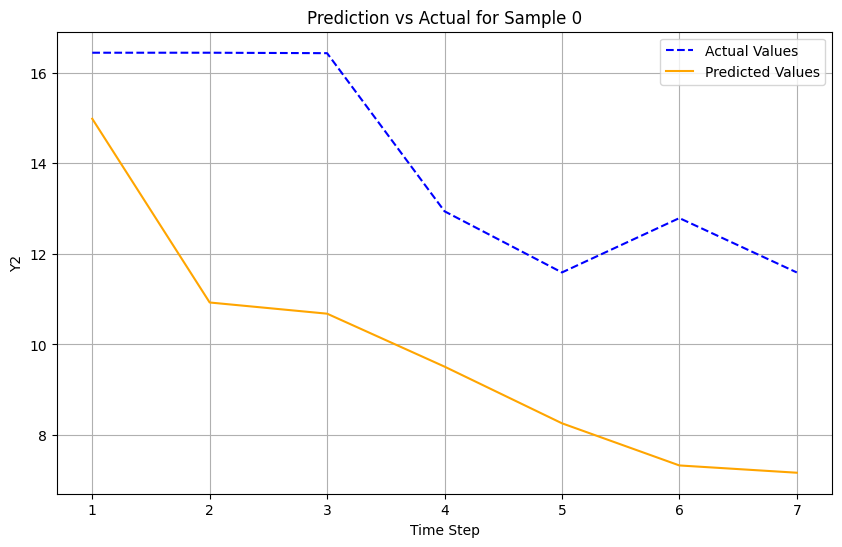

In [21]:
import matplotlib.pyplot as plt

y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)
y_pred_rescaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred.shape)

# Select one test sample
sample_index = 0
actual_values = y_test_rescaled[sample_index].flatten()
predicted_values = y_pred_rescaled[sample_index].flatten()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(actual_values) + 1), actual_values, label="Actual Values", linestyle='dashed', color='blue')
plt.plot(range(1, len(predicted_values) + 1), predicted_values, label="Predicted Values", color='orange')
plt.title(f"Prediction vs Actual for Sample {sample_index}")
plt.xlabel("Time Step")
plt.ylabel("Y2")
plt.legend()
plt.grid()
plt.show()


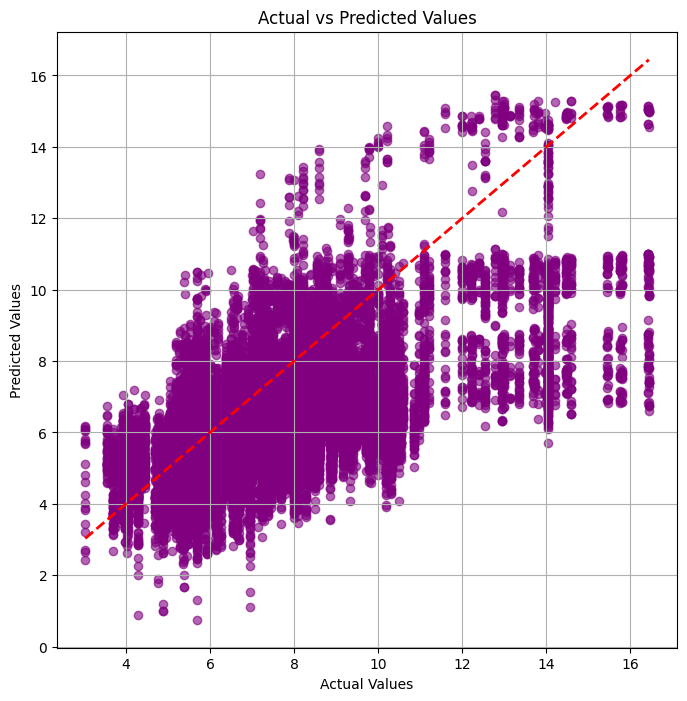

In [22]:
# Flatten predictions and actual values
all_actual_values = y_test_rescaled.flatten()
all_predicted_values = y_pred_rescaled.flatten()

# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(all_actual_values, all_predicted_values, alpha=0.6, color='purple')
plt.plot([all_actual_values.min(), all_actual_values.max()],
         [all_actual_values.min(), all_actual_values.max()], 'r--', lw=2)
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid()
plt.show()


## Improve the transformer
### Add lag features for the past 30 days
### RNN to LSTM in encoder and decoder

In [23]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, Dropout, Add, LayerNormalization

# Load the dataset
file_path = 'Duke.xlsx'  # Replace with your file path
data = pd.ExcelFile(file_path)
df = data.parse('Sheet1')
df = df.sort_values(by='PublishDate')

# Convert PublishDate to datetime and set as index
df['PublishDate'] = pd.to_datetime(df['PublishDate'])
df.set_index('PublishDate', inplace=True)

# Extract relevant columns
selected_data = df[['Y1', 'Z1', 'Z2', 'Z3', 'Z4', 'Y2']]

# Add lag features for the past 30 days
for lag in range(1,31):
    selected_data[f'Y2_lag_{lag}'] = selected_data['Y2'].shift(lag)

C:\Users\ji.702\AppData\Local\Temp\1\ipykernel_8228\1342604926.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data[f'Y2_lag_{lag}'] = selected_data['Y2'].shift(lag)
C:\Users\ji.702\AppData\Local\Temp\1\ipykernel_8228\1342604926.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data[f'Y2_lag_{lag}'] = selected_data['Y2'].shift(lag)
C:\Users\ji.702\AppData\Local\Temp\1\ipykernel_8228\1342604926.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [24]:
def create_sequences(data, target, time_steps, target_steps):
    encoder_inputs, decoder_inputs, targets = [], [], []
    for i in range(len(data) - time_steps - target_steps):
        # Encoder input: Last `time_steps` days
        encoder_inputs.append(data[i:i + time_steps])
        
        # Decoder input: Zeros for the first time step + covariates for target period
        decoder_inputs.append(data[i + time_steps - 1:i + time_steps + target_steps - 1])
        
        # Targets: Next `target_steps` days of Y2
        targets.append(target[i + time_steps:i + time_steps + target_steps])
    
    return np.array(encoder_inputs), np.array(decoder_inputs), np.array(targets)

# Drop rows with NaN values created by lagging
selected_data.dropna(inplace=True)

# Separate features and target
X = selected_data.drop(columns=['Y2'])
y = selected_data['Y2']

# Parameters
time_steps = 7  # Encoder input length
target_steps = 7  # Decoder output length

# Create sequences
encoder_inputs, decoder_inputs, targets = create_sequences(X, y, time_steps, target_steps)

# Normalize the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Recreate sequences with normalized data
encoder_inputs, decoder_inputs, targets = create_sequences(X_scaled, y_scaled, time_steps, target_steps)

In [25]:
from sklearn.model_selection import train_test_split

# Split into training (60%), validation (20%), and test (20%)
X_train, X_temp, decoder_train, decoder_temp, y_train, y_temp = train_test_split(
    encoder_inputs, decoder_inputs, targets, test_size=0.4, random_state=42)
X_val, X_test, decoder_val, decoder_test, y_val, y_test = train_test_split(
    X_temp, decoder_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train shapes: {X_train.shape}, {decoder_train.shape}, {y_train.shape}")
print(f"Validation shapes: {X_val.shape}, {decoder_val.shape}, {y_val.shape}")
print(f"Test shapes: {X_test.shape}, {decoder_test.shape}, {y_test.shape}")

Train shapes: (16332, 7, 35), (16332, 7, 35), (16332, 7, 1)
Validation shapes: (5444, 7, 35), (5444, 7, 35), (5444, 7, 1)
Test shapes: (5445, 7, 35), (5445, 7, 35), (5445, 7, 1)


In [26]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [27]:
import torch
import torch.nn as nn
import torch.optim as optim

class Encoder(nn.Module):
    def __init__(self, encoder_input_size, hidden_size):
        super().__init__()
        self.rnn = nn.LSTM(encoder_input_size, hidden_size, batch_first=True)

    def forward(self, encoder_inputs):
        outputs, (hidden, cell) = self.rnn(encoder_inputs)  # LSTM returns (hidden, cell)
        return outputs, (hidden, cell)

    
class Decoder(nn.Module):
    def __init__(self, decoder_input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.LSTM(decoder_input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  # Output a single value per time step

    def forward(self, decoder_inputs, encoder_outputs, hidden, teacher_force_probability=0.5):
        # decoder_inputs: [batch_size, seq_len, input_size]
        # encoder_outputs: [batch_size, seq_len, hidden_size]
        # hidden: Tuple of (h_n, c_n) for LSTM
        batch_size, seq_len, _ = decoder_inputs.size()
        outputs = torch.zeros(batch_size, seq_len, 1).to(decoder_inputs.device)

        for t in range(seq_len):
            input_t = decoder_inputs[:, t, :].unsqueeze(1)  # [batch_size, 1, input_size]
            output, hidden = self.rnn(input_t, hidden)  # LSTM hidden is a tuple (h_n, c_n)
            outputs[:, t, :] = self.fc(output.squeeze(1))  # [batch_size, 1]
        return outputs

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, encoder_inputs, decoder_inputs, targets=None, teacher_force_probability=0.5):
        # Encoder forward pass
        encoder_outputs, (hidden, cell) = self.encoder(encoder_inputs)

        # Decoder forward pass
        outputs = self.decoder(decoder_inputs, encoder_outputs, (hidden, cell), teacher_force_probability)
        return outputs

In [28]:
# Define model parameters
encoder_input_size = X_train.shape[2]  # Number of features
decoder_input_size = X_train.shape[2]  # Same as encoder for simplicity
hidden_size = 64
output_size = 1  # Predict Y2

# Initialize model
encoder = Encoder(encoder_input_size, hidden_size)
decoder = Decoder(decoder_input_size, hidden_size, output_size)
model = Seq2Seq(encoder, decoder).to(device)

# Define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    encoder_inputs = torch.tensor(X_train).float().to(device)
    decoder_inputs = torch.zeros_like(encoder_inputs).to(device)  # Start with zeros
    targets = torch.tensor(y_train).float().to(device)

    outputs = model(encoder_inputs, decoder_inputs, targets, teacher_force_probability=0.5)

    # Compute loss
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")



Epoch 1/50, Loss: 0.16247206926345825
Epoch 2/50, Loss: 0.14822053909301758
Epoch 3/50, Loss: 0.13458934426307678
Epoch 4/50, Loss: 0.12147446721792221
Epoch 5/50, Loss: 0.10880371183156967
Epoch 6/50, Loss: 0.09652483463287354
Epoch 7/50, Loss: 0.08463600277900696
Epoch 8/50, Loss: 0.07322483509778976
Epoch 9/50, Loss: 0.06250681728124619
Epoch 10/50, Loss: 0.05286687985062599
Epoch 11/50, Loss: 0.044894810765981674
Epoch 12/50, Loss: 0.03934567794203758
Epoch 13/50, Loss: 0.036783598363399506
Epoch 14/50, Loss: 0.036696743220090866
Epoch 15/50, Loss: 0.03729543089866638
Epoch 16/50, Loss: 0.03691089153289795
Epoch 17/50, Loss: 0.034921981394290924
Epoch 18/50, Loss: 0.03162122145295143
Epoch 19/50, Loss: 0.027740830555558205
Epoch 20/50, Loss: 0.024026034399867058
Epoch 21/50, Loss: 0.020984889939427376
Epoch 22/50, Loss: 0.01882249303162098
Epoch 23/50, Loss: 0.01749860867857933
Epoch 24/50, Loss: 0.01683095656335354
Epoch 25/50, Loss: 0.01658875308930874
Epoch 26/50, Loss: 0.016555

In [29]:
# Evaluation of training
model.eval()
with torch.no_grad():
    encoder_inputs = torch.tensor(X_train).float().to(device)
    decoder_inputs = torch.zeros_like(encoder_inputs).to(device)  # Start with zeros
    targets = torch.tensor(y_train).float().to(device)

    outputs = model(encoder_inputs, decoder_inputs)

    # Rescale predictions
    outputs_rescaled = scaler_y.inverse_transform(outputs.cpu().numpy().reshape(-1, 7))
    targets_rescaled = scaler_y.inverse_transform(targets.cpu().numpy().reshape(-1, 7))

    # Calculate metrics
    mse = mean_squared_error(targets_rescaled.flatten(), outputs_rescaled.flatten())
    r2 = r2_score(targets_rescaled.flatten(), outputs_rescaled.flatten())

    print("Mean Squared Error:", mse)
    print("R² Score:", r2)

Mean Squared Error: 1.9428326
R² Score: 0.5434324686575193


In [30]:
# Evaluation of validation
model.eval()
with torch.no_grad():
    encoder_inputs = torch.tensor(X_val).float().to(device)
    decoder_inputs = torch.zeros_like(encoder_inputs).to(device)  # Start with zeros
    targets = torch.tensor(y_val).float().to(device)

    outputs = model(encoder_inputs, decoder_inputs)

    # Rescale predictions
    outputs_rescaled = scaler_y.inverse_transform(outputs.cpu().numpy().reshape(-1, 7))
    targets_rescaled = scaler_y.inverse_transform(targets.cpu().numpy().reshape(-1, 7))

    # Calculate metrics
    mse = mean_squared_error(targets_rescaled.flatten(), outputs_rescaled.flatten())
    r2 = r2_score(targets_rescaled.flatten(), outputs_rescaled.flatten())

    print("Mean Squared Error:", mse)
    print("R² Score:", r2)

Mean Squared Error: 1.9707466
R² Score: 0.5356585260374617


In [31]:
# Evaluation
model.eval()
with torch.no_grad():
    encoder_inputs = torch.tensor(X_test).float().to(device)
    decoder_inputs = torch.zeros_like(encoder_inputs).to(device)  # Start with zeros
    targets = torch.tensor(y_test).float().to(device)

    outputs = model(encoder_inputs, decoder_inputs)

    # Rescale predictions
    outputs_rescaled = scaler_y.inverse_transform(outputs.cpu().numpy().reshape(-1, 7))
    targets_rescaled = scaler_y.inverse_transform(targets.cpu().numpy().reshape(-1, 7))

    # Calculate metrics
    mse = mean_squared_error(targets_rescaled.flatten(), outputs_rescaled.flatten())
    r2 = r2_score(targets_rescaled.flatten(), outputs_rescaled.flatten())

    print("Mean Squared Error:", mse)
    print("R² Score:", r2)

Mean Squared Error: 1.9504073
R² Score: 0.5355907739159268


## Improve the transformer
### Add attention


In [32]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, Dropout, Add, LayerNormalization

# Load the dataset
file_path = 'Duke.xlsx'  # Replace with your file path
data = pd.ExcelFile(file_path)
df = data.parse('Sheet1')

# Convert PublishDate to datetime and set as index
df['PublishDate'] = pd.to_datetime(df['PublishDate'])
df.set_index('PublishDate', inplace=True)

# Extract relevant columns
selected_data = df[['Y1', 'Z1', 'Z2', 'Z3', 'Z4', 'Y2']]

# Add lag features for the past 30 days
for lag in range(1,31):
    selected_data[f'Y2_lag_{lag}'] = selected_data['Y2'].shift(lag)

C:\Users\ji.702\AppData\Local\Temp\1\ipykernel_8228\934765141.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data[f'Y2_lag_{lag}'] = selected_data['Y2'].shift(lag)
C:\Users\ji.702\AppData\Local\Temp\1\ipykernel_8228\934765141.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data[f'Y2_lag_{lag}'] = selected_data['Y2'].shift(lag)
C:\Users\ji.702\AppData\Local\Temp\1\ipykernel_8228\934765141.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [33]:
def create_sequences(data, target, time_steps, target_steps):
    encoder_inputs, decoder_inputs, targets = [], [], []
    for i in range(len(data) - time_steps - target_steps):
        # Encoder input: Last `time_steps` days
        encoder_inputs.append(data[i:i + time_steps])
        
        # Decoder input: Zeros for the first time step + covariates for target period
        decoder_inputs.append(data[i + time_steps - 1:i + time_steps + target_steps - 1])
        
        # Targets: Next `target_steps` days of Y2
        targets.append(target[i + time_steps:i + time_steps + target_steps])
    
    return np.array(encoder_inputs), np.array(decoder_inputs), np.array(targets)

# Drop rows with NaN values created by lagging
selected_data.dropna(inplace=True)

# Separate features and target
X = selected_data.drop(columns=['Y2'])
y = selected_data['Y2']

# Parameters
time_steps = 7  # Encoder input length
target_steps = 7  # Decoder output length

# Create sequences
encoder_inputs, decoder_inputs, targets = create_sequences(X, y, time_steps, target_steps)

# Normalize the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Recreate sequences with normalized data
encoder_inputs, decoder_inputs, targets = create_sequences(X_scaled, y_scaled, time_steps, target_steps)

In [34]:
from sklearn.model_selection import train_test_split

# Split into training (60%), validation (20%), and test (20%)
X_train, X_temp, decoder_train, decoder_temp, y_train, y_temp = train_test_split(
    encoder_inputs, decoder_inputs, targets, test_size=0.4, random_state=42)
X_val, X_test, decoder_val, decoder_test, y_val, y_test = train_test_split(
    X_temp, decoder_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train shapes: {X_train.shape}, {decoder_train.shape}, {y_train.shape}")
print(f"Validation shapes: {X_val.shape}, {decoder_val.shape}, {y_val.shape}")
print(f"Test shapes: {X_test.shape}, {decoder_test.shape}, {y_test.shape}")

Train shapes: (16332, 7, 35), (16332, 7, 35), (16332, 7, 1)
Validation shapes: (5444, 7, 35), (5444, 7, 35), (5444, 7, 1)
Test shapes: (5445, 7, 35), (5445, 7, 35), (5445, 7, 1)


In [35]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attention = nn.Linear(hidden_size * 2, hidden_size)  # Combine encoder and decoder states
        self.energy = nn.Linear(hidden_size, 1, bias=False)  # Compute attention weights

    def forward(self, hidden, encoder_outputs):
        # hidden: [batch_size, hidden_size] (decoder hidden state)
        # encoder_outputs: [batch_size, seq_len, hidden_size] (all encoder outputs)
        
        seq_len = encoder_outputs.size(1)

        # Repeat hidden state across the sequence length
        hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)  # [batch_size, seq_len, hidden_size]

        # Concatenate hidden state with encoder outputs
        combined = torch.cat((hidden, encoder_outputs), dim=2)  # [batch_size, seq_len, hidden_size * 2]

        # Compute energy scores
        energy = torch.tanh(self.attention(combined))  # [batch_size, seq_len, hidden_size]
        attention_weights = torch.softmax(self.energy(energy), dim=1)  # [batch_size, seq_len, 1]

        # Compute context vector as weighted sum of encoder outputs
        context = torch.sum(attention_weights * encoder_outputs, dim=1)  # [batch_size, hidden_size]

        return context, attention_weights

class Encoder(nn.Module):
    def __init__(self, encoder_input_size, hidden_size):
        super().__init__()
        self.rnn = nn.LSTM(encoder_input_size, hidden_size, batch_first=True)

    def forward(self, encoder_inputs):
        outputs, (hidden, cell) = self.rnn(encoder_inputs)  # LSTM returns (hidden, cell)
        return outputs, (hidden, cell)

class DecoderWithAttention(nn.Module):
    def __init__(self, decoder_input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.LSTM(decoder_input_size + hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.attention = Attention(hidden_size)

    def forward(self, decoder_inputs, encoder_outputs, hidden, cell, teacher_force_probability=0.5):
        batch_size, seq_len, _ = decoder_inputs.size()
        outputs = torch.zeros(batch_size, seq_len, 1).to(decoder_inputs.device)

        for t in range(seq_len):
            input_t = decoder_inputs[:, t, :].unsqueeze(1)  # [batch_size, 1, input_size]
            
            # Compute attention context
            context, _ = self.attention(hidden[0].squeeze(0), encoder_outputs)  # [batch_size, hidden_size]
            context = context.unsqueeze(1)  # [batch_size, 1, hidden_size]

            # Concatenate context with decoder input
            input_combined = torch.cat((input_t, context), dim=2)  # [batch_size, 1, input_size + hidden_size]

            # Pass through LSTM
            output, (hidden, cell) = self.rnn(input_combined, (hidden, cell))

            # Generate output
            outputs[:, t, :] = self.fc(output.squeeze(1))  # [batch_size, 1]

        return outputs

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, encoder_inputs, decoder_inputs, targets=None, teacher_force_probability=0.5):
        # Encoder forward pass
        encoder_outputs, (hidden, cell) = self.encoder(encoder_inputs)

        # Decoder forward pass with attention
        outputs = self.decoder(decoder_inputs, encoder_outputs, hidden, cell, teacher_force_probability)
        return outputs


In [37]:
# Define model parameters
encoder_input_size = X_train.shape[2]  # Number of features
decoder_input_size = X_train.shape[2]  # Same as encoder for simplicity
hidden_size = 64
output_size = 1  # Predict Y2

# Initialize model
encoder = Encoder(encoder_input_size, hidden_size)
decoder = DecoderWithAttention(decoder_input_size, hidden_size, output_size)
model = Seq2Seq(encoder, decoder).to(device)

# Define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    encoder_inputs = torch.tensor(X_train).float().to(device)
    decoder_inputs = torch.zeros_like(encoder_inputs).to(device)
    targets = torch.tensor(y_train).float().to(device)

    outputs = model(encoder_inputs, decoder_inputs, targets, teacher_force_probability=0.5)

    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")


Epoch 1/50, Loss: 0.27077990770339966
Epoch 2/50, Loss: 0.235147163271904
Epoch 3/50, Loss: 0.20176777243614197
Epoch 4/50, Loss: 0.16989760100841522
Epoch 5/50, Loss: 0.1392224282026291
Epoch 6/50, Loss: 0.10969073325395584
Epoch 7/50, Loss: 0.08156850934028625
Epoch 8/50, Loss: 0.055602189153432846
Epoch 9/50, Loss: 0.033241529017686844
Epoch 10/50, Loss: 0.016874082386493683
Epoch 11/50, Loss: 0.00980957318097353
Epoch 12/50, Loss: 0.014774136245250702
Epoch 13/50, Loss: 0.027730299159884453
Epoch 14/50, Loss: 0.036640286445617676
Epoch 15/50, Loss: 0.03645959496498108
Epoch 16/50, Loss: 0.03010428324341774
Epoch 17/50, Loss: 0.022077662870287895
Epoch 18/50, Loss: 0.01549129094928503
Epoch 19/50, Loss: 0.011594841256737709
Epoch 20/50, Loss: 0.010296845808625221
Epoch 21/50, Loss: 0.01086204033344984
Epoch 22/50, Loss: 0.01242543663829565
Epoch 23/50, Loss: 0.01425770204514265
Epoch 24/50, Loss: 0.015851547941565514
Epoch 25/50, Loss: 0.016915464773774147
Epoch 26/50, Loss: 0.01733

In [38]:
# Evaluation of training
model.eval()
with torch.no_grad():
    encoder_inputs = torch.tensor(X_train).float().to(device)
    decoder_inputs = torch.zeros_like(encoder_inputs).to(device)  # Start with zeros
    targets = torch.tensor(y_train).float().to(device)

    outputs = model(encoder_inputs, decoder_inputs)

    # Rescale predictions
    outputs_rescaled = scaler_y.inverse_transform(outputs.cpu().numpy().reshape(-1, 7))
    targets_rescaled = scaler_y.inverse_transform(targets.cpu().numpy().reshape(-1, 7))

    # Calculate metrics
    mse = mean_squared_error(targets_rescaled.flatten(), outputs_rescaled.flatten())
    r2 = r2_score(targets_rescaled.flatten(), outputs_rescaled.flatten())

    print("Mean Squared Error:", mse)
    print("R² Score:", r2)

Mean Squared Error: 1.8268996
R² Score: 0.5715377317411532


In [39]:
# Evaluation of validation
model.eval()
with torch.no_grad():
    encoder_inputs = torch.tensor(X_val).float().to(device)
    decoder_inputs = torch.zeros_like(encoder_inputs).to(device)  # Start with zeros
    targets = torch.tensor(y_val).float().to(device)

    outputs = model(encoder_inputs, decoder_inputs)

    # Rescale predictions
    outputs_rescaled = scaler_y.inverse_transform(outputs.cpu().numpy().reshape(-1, 7))
    targets_rescaled = scaler_y.inverse_transform(targets.cpu().numpy().reshape(-1, 7))

    # Calculate metrics
    mse = mean_squared_error(targets_rescaled.flatten(), outputs_rescaled.flatten())
    r2 = r2_score(targets_rescaled.flatten(), outputs_rescaled.flatten())

    print("Mean Squared Error:", mse)
    print("R² Score:", r2)

Mean Squared Error: 1.8467058
R² Score: 0.5655284054409824


In [40]:
# Evaluation of testing
model.eval()
with torch.no_grad():
    encoder_inputs = torch.tensor(X_test).float().to(device)
    decoder_inputs = torch.zeros_like(encoder_inputs).to(device)  # Start with zeros
    targets = torch.tensor(y_test).float().to(device)

    outputs = model(encoder_inputs, decoder_inputs)

    # Rescale predictions
    outputs_rescaled = scaler_y.inverse_transform(outputs.cpu().numpy().reshape(-1, 7))
    targets_rescaled = scaler_y.inverse_transform(targets.cpu().numpy().reshape(-1, 7))

    # Calculate metrics
    mse = mean_squared_error(targets_rescaled.flatten(), outputs_rescaled.flatten())
    r2 = r2_score(targets_rescaled.flatten(), outputs_rescaled.flatten())

    print("Mean Squared Error:", mse)
    print("R² Score:", r2)

Mean Squared Error: 1.8246508
R² Score: 0.5621037441294547
